In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision
import datasets
from datasets import load_dataset
from ucimlrepo import fetch_ucirepo 
import nevergrad as ng
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import os
from tqdm import tqdm

import sys
sys.path.append("../")

from custom_datasets import WineDataset, LSTMDataset
from utils import get_LSTM_dataloaders, isEnglish, lowerCase, build_vocabulary
from models import CNN_Simple,All_CNN_C,VAE,LSTM,Simple_Net

In [9]:
#Set device as GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(device)

cpu


In [10]:
#Function to load the model parameters correctly
def load_params(model, param_tensor):
    current_index = 0

    for param in model.parameters():
        param_length = param.numel()
        param.data = param_tensor[current_index:current_index + param_length].reshape(param.size()).to(device)
        current_index += param_length

In [11]:
#Training the model
class TrainManager:
    def __init__(self, model, dataloader_train, dataloader_test, loss, device, isLSTM=False):
        self.device = device
        self.model = model.to(self.device)
        self.loss = loss.to(self.device)
        self.best_model = None
        self.dataloader_train = dataloader_train
        self.dataloader_test = dataloader_test
        self.best_score = 1e9
        self.epoch = 1
        self.n_samples = len(dataloader_train)
        self.iteration = 0
        self.test_losses = []
        self.train_losses = []
        self.accuracy = []
        self.LSTM = isLSTM
            
    def evaluate(self):
        total_correct,total_samples,loss = 0,0,0

        if not self.LSTM:
            for x , y in self.dataloader_test:
                x,y = x.to(self.device),y.to(self.device)
                y = y.flatten()

                predicted = self.model(x)     
                loss += self.loss(predicted, y).item() #Computed loss

                predicted_labels = torch.argmax(predicted, axis=1) #Predicted labels for classifier problem
                total_correct += torch.sum(y == predicted_labels).item() #Total number of correctly predicted labels
                total_samples += y.numel()

        else: #Special case for LSTM
            for i, data in enumerate(self.dataloader_test):
                inputs = data.to(self.device)
                labels = inputs[:, 1:].to(self.device)

                predicted = self.model(inputs).to(self.device)
                predicted = predicted[:, :-1, :].permute(0, 2, 1)
                loss += self.loss(predicted, labels).item()

                predicted_labels = torch.argmax(predicted, axis=1).to(self.device)
                total_correct += torch.sum(labels == predicted_labels).item()
                total_samples += labels.numel()

        return loss, total_correct/total_samples #Return loss and accuracy

    def cost_function(self, parameters):
        load_params(self.model, torch.tensor(parameters))

        if not self.LSTM:
            # Load the next batch
            inputs, labels = next(iter(self.dataloader_train))
            inputs,labels = inputs.to(self.device),labels.to(self.device)
            predicted = self.model(inputs).to(self.device)
            loss = self.loss(predicted, labels.flatten()).item()

        else:
                for i,data in enumerate(self.dataloader_train):
                    if i == self.iteration % self.n_samples:
                         inputs = data.to(self.device)
                labels = inputs[:,1:].to(self.device)
                predicted = self.model(inputs).to(self.device)
                predicted = predicted[:, :-1, :].permute(0, 2, 1)
                loss = self.loss(predicted, labels).item()

        test_loss, accuracy = self.evaluate()
        if self.best_score > test_loss : #update best score
            self.best_score = test_loss
            self.best_model = copy.deepcopy(self.model)

        print(f'Epoch {self.epoch}, batch {self.iteration % self.n_samples +1}; test loss function : {test_loss}, accuracy: {accuracy:.2f}')

        self.test_losses.append(test_loss)
        self.train_losses.append(loss)
        self.accuracy.append(accuracy)
        
        self.iteration += 1
        if self.iteration % self.n_samples == 0: 
            self.epoch += 1

        return loss

To toggle optimizers, change all instances of NGOpt to SPSA and vice versa (including in file names)

P0 : wine-dataset (small model)

In [13]:
#Set seed for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

#Load the dataset
wine_quality = fetch_ucirepo(id=186) 

x = wine_quality.data.features 
y = wine_quality.data.targets
data = pd.concat([x, y], axis=1)
data_classes = np.sort(data["quality"].unique())

data_train, data_validation = train_test_split(data, random_state=104, test_size=0.25, shuffle=True)

scaler = StandardScaler()
columns_to_normalize = data_train.columns[data_train.columns != "quality"].tolist()
data_train[columns_to_normalize] = scaler.fit_transform(data_train[columns_to_normalize])
data_validation[columns_to_normalize] = scaler.transform(data_validation[columns_to_normalize])

dataset_train = WineDataset(data_train,data_classes)
dataset_validation = WineDataset(data_validation,data_classes)
training_loader = DataLoader(dataset_train,batch_size=len(dataset_train)//1,shuffle=True)
validation_loader = DataLoader(dataset_validation,batch_size=len(dataset_validation)//1,shuffle=False)

In [14]:
#Load model and loss function
model = Simple_Net(len(data_classes)).to(device)
torch.save(model.state_dict(), 'models/Simple_Net.pt')
model.load_state_dict(torch.load('models/Simple_Net.pt'))
loss = nn.CrossEntropyLoss()

Restart here for different optimizers

In [22]:
#Set hyperparameters
epochs = 100
nb_batch = len(training_loader)
trainer = TrainManager(model, training_loader, validation_loader, loss, device)
fitness = trainer.cost_function

# Compute number of parameters of the model + initialize parametrization
init_params = torch.concatenate([p.data.flatten() for p in trainer.model.parameters()])
parametrization = ng.p.Array(init=init_params.cpu())
optimizer = ng.optimizers.SPSA(parametrization=parametrization, budget=epochs*nb_batch, num_workers=1)
optimizer.a = 1
print(f'{epochs} epochs; {nb_batch} batchs')

100 epochs; 1 batchs


In [23]:
#Optimize the model
learned_param = optimizer.minimize(fitness)

/Users/m/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1, batch 1; test loss function : 1.9501307249889408, accuracy: 0.15
Epoch 2, batch 1; test loss function : 1.9551094955610318, accuracy: 0.11
Epoch 3, batch 1; test loss function : 1.9496739559108756, accuracy: 0.02
Epoch 4, batch 1; test loss function : 1.9514165014579965, accuracy: 0.19
Epoch 5, batch 1; test loss function : 1.9427548067903213, accuracy: 0.19
Epoch 6, batch 1; test loss function : 1.9526247253072164, accuracy: 0.07
Epoch 7, batch 1; test loss function : 1.9465139512481329, accuracy: 0.23
Epoch 8, batch 1; test loss function : 1.9464219490836756, accuracy: 0.07
Epoch 9, batch 1; test loss function : 1.9426978270741977, accuracy: 0.16
Epoch 10, batch 1; test loss function : 1.9590532307506272, accuracy: 0.07
Epoch 11, batch 1; test loss function : 1.9336002100607852, accuracy: 0.39
Epoch 12, batch 1; test loss function : 1.9591555312689204, accuracy: 0.01
Epoch 13, batch 1; test loss function : 1.9421790704451432, accuracy: 0.33
Epoch 14, batch 1; test loss funct

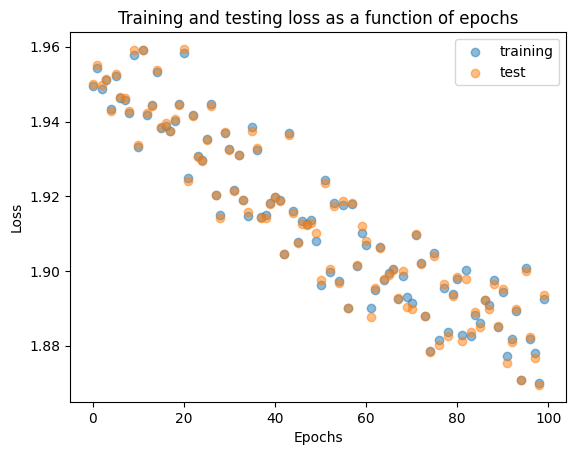

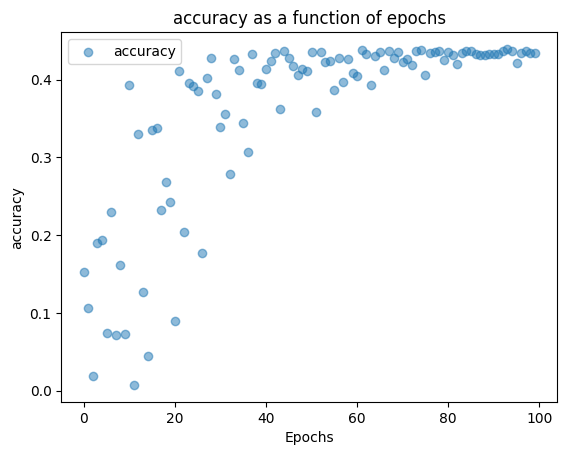

In [25]:
#Plot the results
plt.scatter(range(0,len(trainer.train_losses)),trainer.train_losses, label="training", alpha=0.5)
plt.scatter(range(0,len(trainer.test_losses)),trainer.test_losses, label="test", alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title("Training and testing loss as a function of epochs")
plt.legend()
plt.show()

plt.scatter(range(0,len(trainer.accuracy)), trainer.accuracy, label="accuracy", alpha=0.5)
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.title("accuracy as a function of epochs")
plt.legend()
plt.show()

In [ ]:
#Save the results
torch.save(torch.tensor(trainer.test_losses), 'results/NGOpttestloss_P0.pt')
torch.save(torch.tensor(trainer.train_losses), 'results/NGOpttrainloss_P0.pt')
torch.save(torch.tensor(trainer.accuracy), 'results/NGOptaccuracy_P0.pt')
optimizer._select_optimizer_cls()

MetaModelOnePlusOne

P1 : simple CNN for classification of Fashion MNIST

In [ ]:
#Set seed for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

#Load the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: x.double()),
    transforms.Normalize((0.5,), (0.5,))])
training_set = torchvision.datasets.FashionMNIST("./data", train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST("./data", train=False, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=len(training_set)//2, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=len(validation_set)//2, shuffle=False)

In [ ]:
#Load model and loss function
model = CNN_Simple().to(device)
torch.save(model.state_dict(), 'models/CNN_Simple.pt')
model.load_state_dict(torch.load('models/CNN_Simple.pt'))
loss = nn.CrossEntropyLoss()

Restart here for different optimizers

In [ ]:
#Set hyperparameters
epochs = 20
nb_batch = len(training_loader)
trainer = TrainManager(model, training_loader, validation_loader, loss, device)
fitness = trainer.cost_function

# Compute number of parameters of the model + initialize parametrization
init_params = torch.concatenate([p.data.flatten() for p in trainer.model.parameters()])
parametrization = ng.p.Array(init=init_params.cpu())
optimizer = ng.optimizers.SPSA(parametrization=parametrization, budget=epochs*nb_batch, num_workers=1)
optimizer.a = 1


20 epochs; 2 batchs


In [ ]:
#Optimize the model
learned_param = optimizer.minimize(fitness)

epoch 1 batch 1; test loss function : 4.613806647742187, accuracy: 0.10 best score : 4.613806647742187
epoch 1 batch 2; test loss function : 134390.43246074158, accuracy: 0.12 best score : 4.613806647742187
epoch 2 batch 1; test loss function : 121606.24705773633, accuracy: 0.14 best score : 4.613806647742187
epoch 2 batch 2; test loss function : 40210.8546149481, accuracy: 0.08 best score : 4.613806647742187
epoch 3 batch 1; test loss function : 19870.65201146176, accuracy: 0.12 best score : 4.613806647742187
epoch 3 batch 2; test loss function : 15272.821070587637, accuracy: 0.10 best score : 4.613806647742187
epoch 4 batch 1; test loss function : 2591.7232981163334, accuracy: 0.12 best score : 4.613806647742187
epoch 4 batch 2; test loss function : 4362.631100549586, accuracy: 0.11 best score : 4.613806647742187
epoch 5 batch 1; test loss function : 788.7964528499963, accuracy: 0.09 best score : 4.613806647742187
epoch 5 batch 2; test loss function : 617.3922613192615, accuracy: 0.0

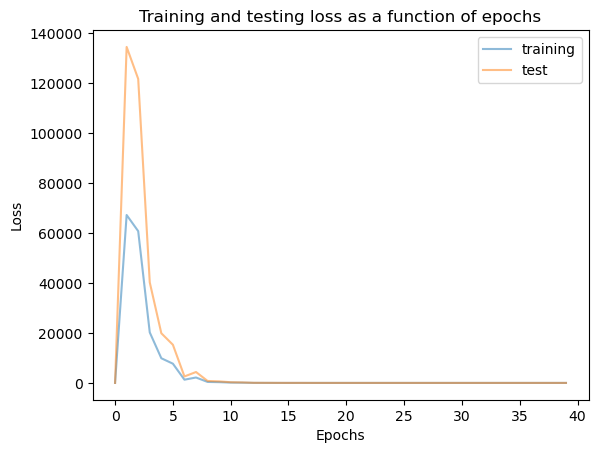

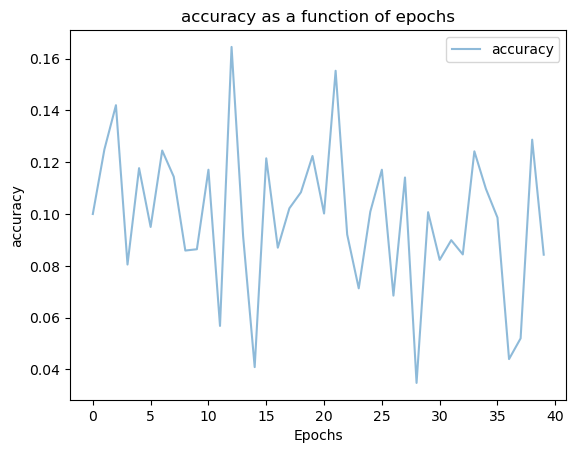

In [ ]:
#Plot the results
plt.scatter(range(0,len(trainer.train_losses)), trainer.train_losses, label="training", alpha=0.5)
plt.scatter(range(0, len(trainer.test_losses)), trainer.test_losses, label="test", alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title("Training and testing loss as a function of epochs")
plt.legend()
plt.show()

plt.scatter(len(trainer.accuracy), trainer.accuracy, label="accuracy", alpha=0.5)
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.title("accuracy as a function of epochs")
plt.legend()
plt.show()

In [ ]:
#Save the results
torch.save(torch.tensor(trainer.test_losses), 'results/NGOptloss_P1.pt')
torch.save(torch.tensor(trainer.accuracy), 'results/NGOptaccuracy_P1.pt')
optimizer._select_optimizer_cls()

MetaModelOnePlusOne

P3: VAE for generation on MNIST

In [ ]:
#Set seed for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

#Load the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: x.double()),
    transforms.Normalize((0.5,), (0.5,))])
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=len(training_set)//100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=len(validation_set)//100, shuffle=False)

In [ ]:
#Load model and loss function
model = VAE().to(device)
loss = nn.CrossEntropyLoss()
model.load_state_dict(torch.load('models/VAE.pt'))
torch.save(model.state_dict(), 'models/VAE.pt')

Restart here for different optimizers

In [ ]:
#Set hyperparameters
epochs = 1
nb_batch = len(training_loader)
trainer = TrainManager(model, training_loader, validation_loader, loss, device)
fitness = trainer.cost_function

# Compute number of parameters of the model + initialize parametrization
init_params = torch.concatenate([p.data.flatten() for p in trainer.model.parameters()])
parametrization = ng.p.Array(init=init_params.cpu())
optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=epochs*nb_batch, num_workers=1)
optimizer.a = 1
print(f'{epochs} epochs; {nb_batch} batchs')

1 epochs; 100 batchs


In [ ]:
#Optimize the model
learned_param = optimizer.minimize(fitness)

epoch 1 batch 1; test loss function : 665.9557523603048, accuracy: 0.00 best score : 665.9557523603048
epoch 1 batch 2; test loss function : 687.6216163558015, accuracy: 0.07 best score : 665.9557523603048
epoch 1 batch 3; test loss function : 659.396300483929, accuracy: 0.10 best score : 659.396300483929
epoch 1 batch 4; test loss function : 673.1719082538658, accuracy: 0.12 best score : 659.396300483929
epoch 1 batch 5; test loss function : 680.5037775377698, accuracy: 0.09 best score : 659.396300483929
epoch 1 batch 6; test loss function : 674.9386368155492, accuracy: 0.10 best score : 659.396300483929
epoch 1 batch 7; test loss function : 659.1685841230908, accuracy: 0.12 best score : 659.1685841230908
epoch 1 batch 8; test loss function : 669.2538022410831, accuracy: 0.11 best score : 659.1685841230908
epoch 1 batch 9; test loss function : 669.8856130034834, accuracy: 0.10 best score : 659.1685841230908
epoch 1 batch 10; test loss function : 681.3374644055126, accuracy: 0.09 best 

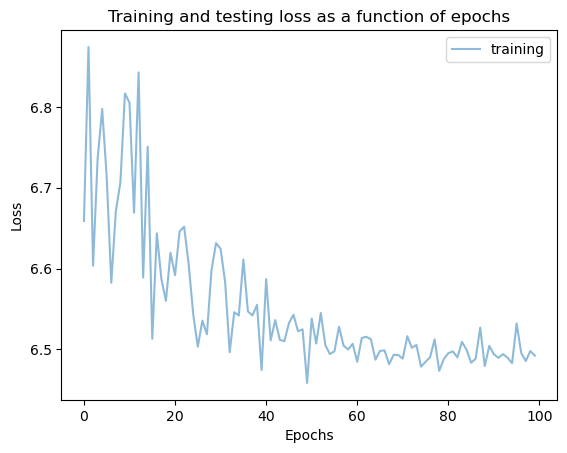

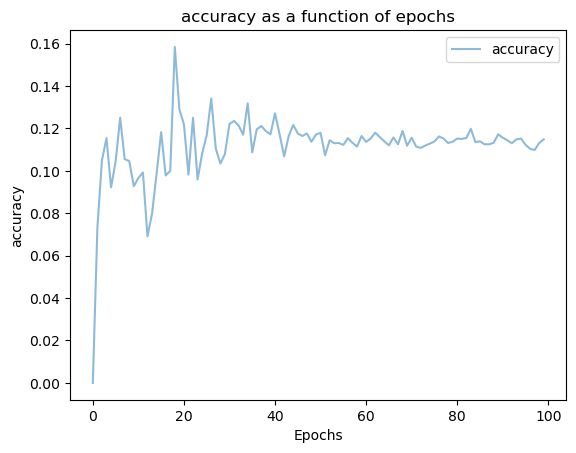

In [ ]:
# Plot the results
plt.scatter(range(0,len(trainer.train_losses)), trainer.train_losses, label="training", alpha=0.5)
plt.scatter(range(0,len(trainer.test_losses)), trainer.test_losses, label="test", alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title("Training and testing loss as a function of epochs")
plt.legend()
plt.show()

plt.scatter(range(0,trainer.accuracy), trainer.accuracy, label="accuracy", alpha=0.5)
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.title("accuracy as a function of epochs")
plt.legend()
plt.show()

In [ ]:
#Save the results
torch.save(torch.tensor(trainer.test_losses), 'results/NGOptloss_P1.pt')
torch.save(torch.tensor(trainer.accuracy), 'results/NGOptaccuracy_P1.pt')
optimizer._select_optimizer_cls()

P4: All-CNNC-C for classification on CIFAR-100

In [ ]:
#Set seed for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Lambda(lambda x: x.double()),
    transforms.Normalize((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))]
)

#Load the dataset
training_set = torchvision.datasets.CIFAR100('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.CIFAR100('./data', train=False, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=len(training_set)//50, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=len(validation_set)//50, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Load model and loss function
model = All_CNN_C().to(device)
loss = torch.nn.CrossEntropyLoss()
model.load_state_dict(torch.load('models/All_CNN_C.pt'))
torch.save(model.state_dict(), 'models/All_CNN_C.pt')

restart here for evaluating with different optimizers

In [ ]:
#Set hyperparameters
epochs = 1
nb_batch = len(training_loader)
trainer = TrainManager(model, training_loader, validation_loader, loss, device)
fitness = trainer.cost_function

# Compute number of parameters of the model + initialize parametrization
init_params = torch.concatenate([p.data.flatten() for p in trainer.model.parameters()])
parametrization = ng.p.Array(init=init_params)
optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=epochs*nb_batch, num_workers=1)
optimizer.a = 1

1 epochs; 50 batchs


In [ ]:
#Optimize the model
learned_param = optimizer.minimize(fitness)

epoch 1; test loss function : 230.27030162775776, accuracy: 0.01 best score : 230.27030162775776


KeyboardInterrupt: 

P5: next word generation (2-layer bidirectional LSTM trained on wikitext-2)

In [ ]:
#Plot the results
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
from datasets import load_dataset
dataset = load_dataset("wikitext", 'wikitext-2-v1', split='train')

In [ ]:
#Filter the data
import re
dataset = dataset.filter(lambda x: 100 <= len(x['text'].split()) <= 128)
dataset = dataset.filter(lambda x: not re.match(" = .* = \n", x['text']))
dataset = dataset.filter(lambda x: isEnglish(x['text']))
dataset = dataset.map(lambda x: lowerCase(x))

In [ ]:
#Build the vocabulary
wikitext_dataset, token_freq_dict = build_vocabulary(dataset, min_freq=5, unk_token='<unk>')

In [ ]:
#Define LSTM Dataset Class
class LSTMDataset(Dataset):
    def __init__(self,
                 dataset: datasets.arrow_dataset.Dataset,
                 max_seq_length: int, ):
        self.train_data = self.prepare_dataset(dataset)
        self.max_seq_length = max_seq_length + 2  # as <start> and <stop> will be added
        self.dataset_vocab = self.get_vocabulary(dataset)
        self.token2idx = {element: index for index, element in enumerate(self.dataset_vocab)}
        self.idx2token = dict(enumerate(self.dataset_vocab))
        self.pad_idx = self.token2idx["<pad>"]

    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        # Get a list of tokens of the given sequence. Represent each token with its index in `self.token2idx`.
        token_list = self.train_data[idx].split()
        # having a fallback to <unk> token if an unseen word is encoded.
        token_ids = [self.token2idx.get(t, self.token2idx['<unk>']) for t in token_list]

        # Add padding token to the sequence to reach the max_seq_length. 
        token_ids += [self.token2idx['<pad>']] * (self.max_seq_length - len(token_ids))

        return torch.tensor(token_ids)

    def get_vocabulary(self, dataset: datasets.arrow_dataset.Dataset):
        vocab = set()
        print("Getting dataset's vocabulary")
        for sample in tqdm(dataset):
            vocab.update(set(sample["text"].split()))
        vocab.update(set(["<start>", "<stop>", "<pad>"]))
        vocab = sorted(vocab)
        return vocab

    @staticmethod
    def prepare_dataset(target_dataset: datasets.arrow_dataset.Dataset):
        """
        Encapsulate sequences between <start> and <stop>.
        
        :param: target_dataset: the target dataset to extract samples
        return: a list of encapsulated samples.
        """
        prepared_dataset = []
        for sample in target_dataset:
            prepared_dataset.append(f"<start> {sample['text']} <stop>")
        return prepared_dataset

In [ ]:
MAX_SEQ_LENGTH = 128
lstm_dataset = LSTMDataset(dataset=wikitext_dataset,
                         max_seq_length=MAX_SEQ_LENGTH)

Getting dataset's vocabulary


100%|██████████| 1158/1158 [00:00<00:00, 15863.85it/s]


In [ ]:
#Load data
training_loader, validation_loader = get_LSTM_dataloaders(lstm_dataset, test_ratio=0.1)

In [ ]:
vocab_size = len(lstm_dataset.token2idx)
embedding_dim = 100
hidden_dim = 100
dropout_rate = 0.15

In [ ]:
#Load model and loss function
model = LSTM(vocab_size=vocab_size,input_dim=embedding_dim,hidden_dim=hidden_dim,dropout_rate=dropout_rate).to(device)
torch.save(model.state_dict(), 'models/LSTM.pt')
model.load_state_dict(torch.load('models/LSTM.pt'))
loss = torch.nn.CrossEntropyLoss(ignore_index=lstm_dataset.pad_idx)

restart here for evaluating different optimizers

In [ ]:
#Set hyperparameters
epochs = 2
trainer = TrainManager(model,training_loader,validation_loader,loss,device,True)
fitness = trainer.cost_function
print(f'{epochs} epochs, {len(training_loader)} batchs')
# Compute number of parameters of the model + initialize parametrization
num_params = sum(p.numel() for p in model.parameters())
parametrization = ng.p.Array(shape=(num_params,))
optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=epochs*len(training_loader))


2 epochs, 3 batchs


In [ ]:
#Optimize the model
learned_param = optimizer.minimize(fitness)

c:\Programmation\Anaconda\envs\opti4ML\lib\site-packages\torch\nn\modules\rnn.py:911: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


epoch 1 batch 1; test loss function : 16.71498762531713, accuracy: 0.00 best score : 16.71498762531713
epoch 1 batch 2; test loss function : 88.25145693940235, accuracy: 0.00 best score : 16.71498762531713
epoch 1 batch 3; test loss function : 71.80433714611385, accuracy: 0.00 best score : 16.71498762531713
epoch 2 batch 1; test loss function : 61.642945929278994, accuracy: 0.00 best score : 16.71498762531713
epoch 2 batch 2; test loss function : 49.81607574108679, accuracy: 0.00 best score : 16.71498762531713
epoch 2 batch 3; test loss function : 42.0423720986598, accuracy: 0.00 best score : 16.71498762531713


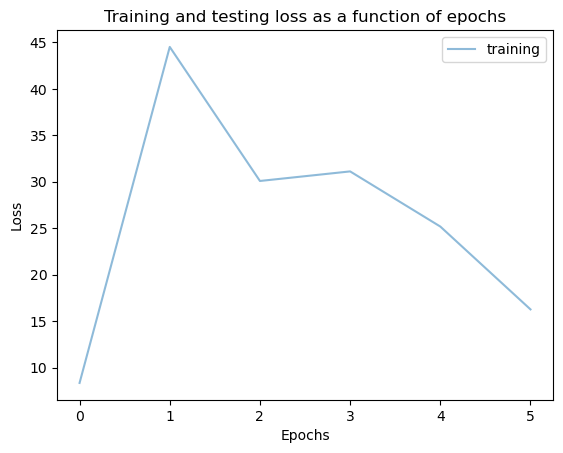

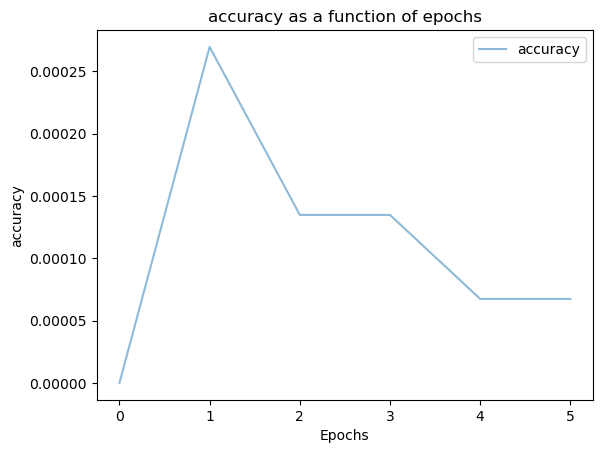

In [ ]:
plt.scatter(range(0,trainer.train_losses), trainer.train_losses, label="training", alpha=0.5)
plt.scatter(range(0,trainer.test_losses), trainer.test_losses, label="test", alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title("Training and testing loss as a function of epochs")
plt.legend()
plt.show()

plt.scatter(range(0,trainer.accuracy), trainer.accuracy, label="accuracy", alpha=0.5)
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.title("accuracy as a function of epochs")
plt.legend()
plt.show()

In [ ]:
#Save the results
torch.save(torch.tensor(loss), 'results/NGOptloss_P5V2.pt')
torch.save(torch.tensor(accuracy), 'results/NGOptaccuracy_P5V2.pt')
optimizer._select_optimizer_cls()

MetaModelOnePlusOne